<a href="https://colab.research.google.com/github/dymiyata/erdos2023_million_playlist_challenge/blob/master/matrix_factorization/matrix_factorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import json
from numba import njit

import sqlalchemy as db

from time import time
from datetime import timedelta

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
# Load functions
from functions import *

# Training the Model

Load the SQL database

In [6]:
db_path = "sqlite:///../MPD_sql.db"
engine = db.create_engine(db_path)
conn = engine.connect()

In [7]:
time_0 = time()
# R_list = make_R_list_sql(conn, pid_limit=10000, progress=10)
R_list = make_R_list_sql(conn, pid_limit=None, progress=10)
time_end = time()

print(str( timedelta(seconds=time_end-time_0) )[:-4])
print()

num_playlists_0 = len(np.unique(R_list[:,0]))
print(f'We have {num_playlists_0} playlists')

1.51%: 2.95 sec
3.01%: 1.65 sec
4.52%: 1.42 sec
6.03%: 1.41 sec
7.54%: 1.41 sec
9.04%: 1.45 sec
10.55%: 1.45 sec
12.06%: 1.44 sec
13.57%: 1.46 sec
15.07%: 1.41 sec
16.58%: 1.42 sec
18.09%: 1.60 sec
19.59%: 1.42 sec
21.10%: 1.44 sec
22.61%: 1.46 sec
24.12%: 1.40 sec
25.62%: 1.38 sec
27.13%: 1.36 sec
28.64%: 1.33 sec
30.14%: 1.55 sec
31.65%: 1.36 sec
33.16%: 1.35 sec
34.67%: 1.56 sec
36.17%: 1.39 sec
37.68%: 1.37 sec
39.19%: 1.36 sec
40.70%: 1.56 sec
42.20%: 1.40 sec
43.71%: 1.39 sec
45.22%: 1.38 sec
46.72%: 1.36 sec
48.23%: 1.60 sec
49.74%: 1.41 sec
51.25%: 1.42 sec
52.75%: 1.16 sec
54.26%: 1.52 sec
55.77%: 1.33 sec
57.28%: 1.55 sec
58.78%: 1.59 sec
60.29%: 1.42 sec
61.80%: 1.41 sec
63.30%: 1.16 sec
64.81%: 1.52 sec
66.32%: 1.33 sec
67.83%: 1.52 sec
69.33%: 1.62 sec
70.84%: 1.41 sec
72.35%: 1.41 sec
73.85%: 1.15 sec
75.36%: 1.52 sec
76.87%: 1.34 sec
78.38%: 1.54 sec
79.88%: 1.60 sec
81.39%: 1.41 sec
82.90%: 1.41 sec
84.41%: 1.15 sec
85.91%: 1.52 sec
87.42%: 1.32 sec
88.93%: 1.54 sec
90.

Create train-test split

In [8]:
# Percentage of the total database to reserve for validation and testing
val_size_abs = 0.15
test_size    = 0.15
shuffle = True

# Note: the first pid_train contains (1-test_size) percent of the data.
# We need to use val_size so that val_size*(1-test_size) = val_size_abs.
val_size = val_size_abs/(1-test_size)
pid_train, pid_test = train_test_split(np.arange(num_playlists_0), test_size=test_size,
                                       shuffle=shuffle, random_state=11)
pid_train, pid_val  = train_test_split(pid_train, test_size=val_size,
                                       shuffle=shuffle, random_state=11)

# Show the first few entries of pid_train
print('Verify the following two lists are equal')
print('to ensure we\'re always using the same train-val-test split')
print(pid_train[:7])
print(np.array([597571, 679779, 758502, 28851, 480077, 430444, 982068]))

Verify the following two lists are equal:
[597571 679779 758502  28851 480077 430444 982068]
[597571 679779 758502  28851 480077 430444 982068]


In [9]:
# Reduce the size of the validation set to make training times small enough
pid_val = pid_val[:5000]

In [10]:
R_list_train = R_list[ np.isin(R_list[:,0], pid_train), :]
R_list_val   = R_list[ np.isin(R_list[:,0], pid_val),   :]
# R_list_test  = R_list[ np.isin(R_list[:,0], pid_test),  :]

# Store the track id of songs in the train/val/test sets
tid_train = np.unique( R_list_train[:,1] )
tid_val   = np.unique( R_list_val[:,1]   )
# tid_test  = np.unique( R_list_test[:,1]  )

num_playlists = len(pid_train)
num_songs = len(tid_train)

print('Number of training playlists:', num_playlists)
print('Number of training songs:', num_songs)

# Delete the whole list (we don't use it again)
# del R_list

Number of training playlists: 700000
Number of training songs: 1903758


We create new variables so that the `tid`s in the `R_idx_*` match with the indices of tracks in the `Q` matrix everywhere

In [11]:
tid_to_idx, _ = list_to_dict(tid_train)

# Remove tracks we don't know from the validation and test sets
# Create new arrays with consecutive tids
# And store the dicts to go from the original pid-tid labeling to the new consecutive indexing
_,           R_idx_train, _,   _  = format_new_R_list(R_list_train, tid_to_idx)
R_list_val,  R_idx_val,   _,   _  = format_new_R_list(R_list_val,  tid_to_idx)
# R_list_test, R_idx_test,  pid_to_idx_test,  idx_to_pid_test  = format_new_R_list(R_list_test,  tid_to_idx)

# Example of training the algorithm

Specify the number of features and create matrices $P$ and $Q$ whose entries are randomly taken from a normal distribution with $\mu = 0$ and $\sigma = 0.1$.

In [20]:
f = 5 # number of latent features
# num_songs = max(reverse_track_dict.keys()) + 1
num_songs = len(tid_train)
num_playlists = len(pid_train)

# initialize random values for matrices P and Q. Entries are between -1 and 1
P = np.random.normal(0, 0.1, (num_playlists, f))
Q = np.random.normal(0, 0.1, (num_songs, f))

Run the gradient descent algorithm and store the resulting matrices in P_trained and Q_trained.

In [21]:
# Run gradient descent algorithm with alpha = 0.001, llambda = 0.005 for 100 iterations
start_time = time()
P_trained, Q_trained = run_epoch(R_idx_train, P, Q, 0.001, 0.001, 1000)
end_time = time()
print('Training done: {:.3f} sec'.format(end_time-start_time))

Training done: 1909.982 sec


For our fixed Q, given a list of (new) playlist ids, we can compute the P matrix that minimizes the training error

In [22]:
# Check the error on the validation set
start_time = time()
P_val = make_Pval(R_idx_val, Q_trained, 0.005)
print('MSE:', MSE(R_idx_val, P_val, Q_trained))
end_time = time()

print('Done: {:.3f} sec'.format(end_time-start_time))

MSE: nan
Done: 3.673 sec


# Find best hyperparameters using grid search

In [13]:
# Hyperparameter tuning using grid search
NUM_ITERATIONS = 1000

# Specify the number of latent features (f), learning rate (alpha), and regularization parameter (llambda)
f_values = np.arange(5,25,5)
alpha_values = np.array([10**-4])
llambda_values = np.array([10**-3])
# llambda_values = 10.**np.arange(-5,-1)
costs = grid_search(f_values, alpha_values, llambda_values, NUM_ITERATIONS)

Processing 1/4:
(1,1,1)/(4,1,1)
Training:   0:28:45.66
Saving:     0:00:00.03
Total time: 0:28:45.70

Processing 2/4:
(2,1,1)/(4,1,1)
Training:   0:47:19.90
Saving:     0:00:00.03
Total time: 1:16:05.65

Processing 3/4:
(3,1,1)/(4,1,1)
Training:   1:04:38.14
Saving:     0:00:00.07
Total time: 2:20:43.87

Processing 4/4:
(4,1,1)/(4,1,1)
Training:   1:10:13.36
Saving:     0:00:00.10
Total time: 3:30:57.33



Additional parameters:
Alpha values: [0.0001]
llambda values: [0.001]


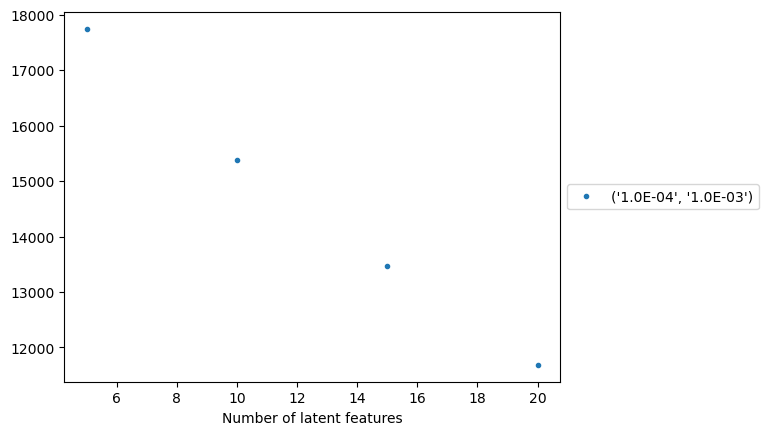

In [14]:
plot_grid_search(costs, f_values, alpha_values, llambda_values)